In [17]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy
from scipy.linalg import cholesky, cho_solve, solve_triangular
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import GPy as gpy
import GPy
import scipy.integrate as integrate


In [18]:
def normal(s):
    return scipy.stats.norm(0.0, np.sqrt(1.0)).pdf(s)

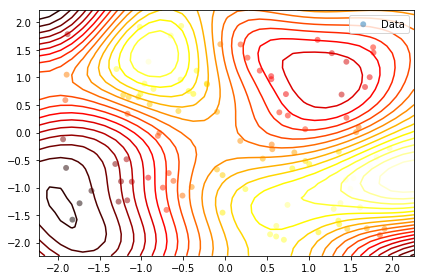

In [19]:
def sample_function(x_range, N=100, seed=4):
#     np.random.seed(seed)
    dx = x_range.shape[1]
    k = gpy.kern.src.rbf.RBF(input_dim=dx,lengthscale=1.0)
    x = np.random.uniform(x_range[0], x_range[1], (N, dx))
    cov = k.K(x, x)
    mu = np.zeros(x.shape[0])
#     y = np.atleast_2d(normal(x[:,1])).T
    y = np.random.multivariate_normal(np.squeeze(mu), cov)[:, None]
    m = gpy.models.GPRegression(x, y, k)#, mean_function=mean)
    m.likelihood.variance = 0.0

    def f(x): return m.predict(x)[0]
    return f,m
x_range = np.array([[-2.0,-2.0], [2.0,2.0]])
f,m = sample_function(x_range)
m.plot()

In [20]:
# k = GPy.kern.src.rbf.RBF(input_dim=1,lengthscale=0.1)
# kernel = RBF(1.0, (1e-2, 1e2))
x = np.random.normal(0,4,(1,2))
print x.shape
y = f(x)
gp = GPy.models.GPRegression(x, y, GPy.kern.src.rbf.RBF(input_dim=2,lengthscale=1.0),noise_var=0.0)

# gp.plot()
# gp

(1, 2)


In [217]:
u,v = gp.predict(np.array([[0.3,0.3]]))
print u, v

def get_mean_func(gp):
    def f(x):
        Kxpx = gp.kern.K(x,gp.X)
        return np.dot(Kxpx,gp.posterior.woodbury_vector)
    return f

def get_cov_func(gp):
    def f(x,y):
        Kxy = gp.kern.K(x,y)
        K1 = gp.kern.K(x,gp.X)
        K2 = gp.kern.K(gp.X,y)
        return Kxy - K1.dot(gp.posterior.woodbury_inv.dot(K2))
    return lambda x,y: f(x,y)

# cov1 = lambda x,y: gp.kern.K(np.array([[x]]),np.array([[y]]))
# cov2 = (lambda x,y: gp.kern.K(np.array([[x]]),gp.X).dot(gp.posterior.woodbury_inv.dot(gp.kern.K(gp.X,np.array([[y]])))))

print get_mean_func(gp)(np.array([[0.3,0.3]]))
print get_cov_func(gp)(np.array([[0.3,0.3]]),np.array([[0.3,0.3]]))

[[1.74998187e-07]] [[1.]]
[[1.74998187e-07]]
[[1.]]


In [68]:
b = np.array([0.0])
B = np.array([[1.0]])
def bintegrate(gp,b,B):
    n,dim = gp.X.shape
    length_scale = gp.kern.lengthscale[0]
    A = length_scale** 2 * np.diag(np.ones(dim))
    I = np.identity(dim)    
    X = gp.X
    z = np.zeros((n, 1))
    determ = np.linalg.det(np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    abinv = np.linalg.inv(A + B)
    for i in range(n):
        x = X[i, :]
        expon = np.exp(-0.5 * np.dot(np.dot((x - b), abinv), (x - b).T))
        z[i, :] = determ * expon
    mean = np.dot(z.T,gp.posterior.woodbury_vector)
    
    var_determ = np.linalg.det(2*np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    var = var_determ - np.dot(z.T, gp.posterior.woodbury_inv.dot(z))
    return mean[0][0], var[0][0]
bintegrate(m,b,B)

ValueError: shapes (2,2) and (1,1) not aligned: 2 (dim 1) != 1 (dim 0)

In [5]:
b = np.array([0.0])
B = np.array([[1.0]])
def integrate_dim(gp, sdim,a,b, B):
    n,_ = gp.X.shape
    length_scale = gp.kern.lengthscale[0]
    A = length_scale** 2 * np.diag(np.ones(sdim))
    I = np.identity(sdim)    
    X = gp.X
    z = np.zeros((n, 1))
    determ = np.linalg.det(np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    abinv = np.linalg.inv(A + B)
    for i in range(n):
        x = X[i, :sdim]
        xa = X[i, sdim:]
        factor = np.exp(-0.5 * np.sum((xa-a)**2 / (length_scale ** 2)))
        expon = np.exp(-0.5 * np.dot(np.dot((x - b), abinv), (x - b).T))
        z[i, :] = factor*determ * expon
    mean = np.dot(z.T,gp.posterior.woodbury_vector)
    var_determ = np.linalg.det(2*np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    var = var_determ - np.dot(z.T, gp.posterior.woodbury_inv.dot(z))
    return mean[0][0], var[0][0], z
mu,var,z =  integrate_dim(gp,1,np.array([0.0]),b,B)
# print mu,var,z


def bq_acquisition(gp,sdim,a,b,B,xs,z):
    length_scale = gp.kern.lengthscale[0]
    A = length_scale** 2 * np.diag(np.ones(sdim))
    I = np.identity(sdim)    
    X = gp.X
    
    var_determ = np.linalg.det(2*np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    determ = np.linalg.det(np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    abinv = np.linalg.inv(A + B)
    variances = np.zeros((xs.shape[0]))
    for i in range(xs.shape[0]):
        x = xs[i, :]
        xa = np.concatenate((xs[i, :],a))
        Xnew = np.vstack((gp.X, xa))
        K = gp.kern.K(Xnew)
        K[np.diag_indices_from(K)] += 1e-10
        ztemp = determ * np.exp(-0.5 * np.dot(np.dot((x - b), abinv), (x - b).T))
        ztemp = np.vstack((z, ztemp))
        L = cholesky(K, lower=True)
        Kz = cho_solve((L, True), ztemp)
        variances[i] = var_determ - np.dot(ztemp.T, Kz)
    sorted_vars = variances.argsort()
    return xs[sorted_vars[:1]]
# print bq_acquisition(gp,1,np.array([0.0]),b,B,np.array([[-1.0],[1.0],[2.0],[3.5]]),z)

In [21]:
b = np.array([0.0])
B = np.array([[1.0]])
gps = []
def OPT(f,gp,b,B,sdim,adim):
    for i in range(100):
        print "iter %d" % i
        actions = np.random.uniform(-4,4, (100, adim))
        UCB = lambda a: integrate_dim(gp, sdim, a, b,B)[0] + 3* np.sqrt(integrate_dim(gp, sdim, a, b,B)[1])
#         Vars = lambda a: 50000000.0 * integrate_dim(gp, sdim, a, prior[0], prior[1])[1]
#         Mus = lambda a: integrate_dim(gp, sdim, a, prior[0], prior[1])[0]
#         D[i] =  (actions, np.apply_along_axis(Mus, 1, actions),np.apply_along_axis(Vars, 1, actions),np.apply_along_axis(UCB, 1, actions))
        maxa = max(actions, key=UCB)
        print maxa
        _,_,z = integrate_dim(gp, sdim, maxa,b,B)
        xs = np.random.uniform(-3.0,3.0, (1000, sdim))
        chosen = bq_acquisition(gp, sdim, maxa, b,B, xs,z)
        X = gp.X
        Y = gp.Y
        chosen_columns = np.repeat(np.reshape(maxa,(1,-1)),chosen.shape[0],axis=0)
        newX = np.hstack((chosen, chosen_columns))
        Xnew = np.vstack((X, newX))
        Yadd = newX.copy()
        Yadd = f(Yadd)
        Ynew = np.vstack((Y, Yadd))
        gp = GPy.models.GPRegression(Xnew, Ynew, GPy.kern.src.rbf.RBF(input_dim=2,lengthscale=1.0),noise_var=0.0)
        gps.append(gp)
#         gp.plot()
    return gp
newgp = OPT(f,gp,b,B,1,1)
        

iter 0
[-3.07756539]
iter 1
[-1.54961416]
iter 2
[0.28600795]
iter 3
[2.26926379]
iter 4
[3.94566252]
iter 5
[-3.98979004]
iter 6
[-0.65556641]
iter 7
[3.16236309]
iter 8
[-2.34036769]
iter 9
[3.37432889]
iter 10
[3.30577389]
iter 11
[1.24017648]
iter 12
[-3.35410497]
iter 13
[-1.03121364]
iter 14
[-0.30758141]
iter 15
[-2.22846295]
iter 16
[2.62813814]
iter 17
[0.86753237]
iter 18
[-3.51797168]
iter 19
[2.84018385]
iter 20
[-1.03284574]
iter 21
[3.58566589]
iter 22
[3.15548247]
iter 23
[-3.98387861]
iter 24
[3.40245769]
iter 25
[3.24053151]
iter 26
[3.16977736]
iter 27
[-3.47125621]
iter 28
[3.21201692]
iter 29
[3.33581425]
iter 30
[3.63449388]
iter 31
[3.14187551]
iter 32
[3.31786996]
iter 33
[3.24602352]
iter 34
[3.15783965]
iter 35
[3.24556068]
iter 36
[3.15941407]
iter 37
[3.20292062]
iter 38
[3.21276438]
iter 39
[3.2808153]
iter 40
[3.22324045]
iter 41
[3.2234138]
iter 42
[3.27128681]
iter 43
[3.18442175]
iter 44
[3.23515238]
iter 45
[3.25505123]
iter 46
[3.15820944]
iter 47
[3.2

 /Library/Python/2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning:invalid value encountered in sqrt


[3.28598279]
iter 55
[3.18323162]
iter 56
[3.31260305]
iter 57
[3.155168]
iter 58
[3.33600641]
iter 59
[3.10675615]
iter 60
[3.18079091]
iter 61
[3.3209624]
iter 62
[3.18123445]
iter 63
[3.25752485]
iter 64
[3.28421007]
iter 65
[3.03673171]
iter 66
[3.2465255]
iter 67
[3.27234569]
iter 68
[-1.22072142]
iter 69
[3.4221033]
iter 70
[3.31470138]
iter 71
[3.33504133]
iter 72
[3.16859039]
iter 73
[3.044511]
iter 74
[3.03567259]
iter 75
[3.22555807]
iter 76
[3.23842876]
iter 77
[3.33235589]
iter 78
[3.23676882]
iter 79
[3.21158079]
iter 80
[3.39174986]
iter 81
[3.46148391]
iter 82
[3.1452441]
iter 83
[3.18253862]
iter 84
[3.25825308]
iter 85
[3.19638875]
iter 86
[3.20547574]
iter 87
[3.20623913]
iter 88
[3.43143995]
iter 89
[3.21340548]
iter 90
[3.22782726]
iter 91
[3.14098558]
iter 92
[3.20448581]
iter 93
[3.24037718]
iter 94
[3.2211609]
iter 95
[3.44975106]
iter 96
[3.16208838]
iter 97
[-3.27938804]
iter 98
[3.22658834]
iter 99
[3.22268676]


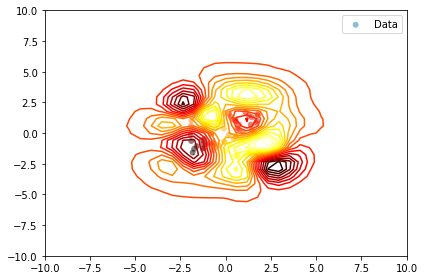

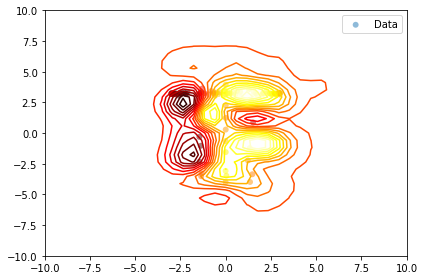

In [22]:
m.plot((-10,10))
gps[-1].plot((-10,10))

REFERENCE


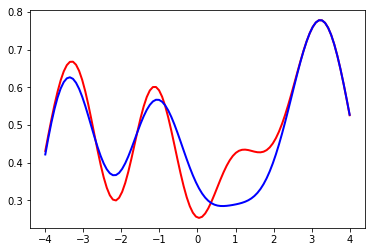

In [31]:
print "REFERENCE"
actions = np.linspace(-4,4,100)
def plot_reference(m,actions):
    mus = []
    var = []
    tot = []
    for a in actions:
        out = integrate_dim(m, 1, a, b,B)
        mus.append(out[0])
        var.append(3*np.sqrt(out[1]))
        tot.append(out[0] + 3*np.sqrt(out[1]))
    plt.plot(actions, mus)
    plt.plot(actions, var)
    plt.plot(actions, tot)
    plt.legend(loc='upper left')
    plt.show()
# plot_reference(gps[11],actions)
def plot_error(m,gp):
    mus1 = []
    mus2 = []
    for a in actions:
        out1 = integrate_dim(m, 1, a, b,B)
        out2 = integrate_dim(gp, 1, a, b,B)
        mus1.append(out1[0])
        mus2.append(out2[0])
    plt.plot(actions, mus1, 'r', lw=2)
    plt.plot(actions, mus2, 'b', lw=2)
    plt.show()
plot_error(m,gps[-2])

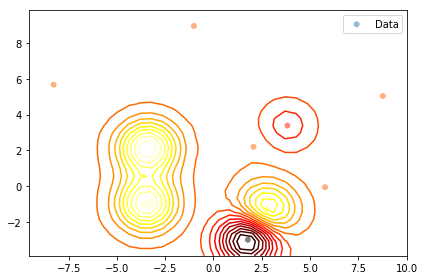

In [169]:
gp.plot()